# Implementation of k-Means
    using the car dataset from the UCI Machine Learning Repository. 
    (source: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation)

### Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

### Load data

In [2]:
# Load data
path = '/Users/slackoverflow/Dropbox/DKE/Machine Learning/Decision Trees/ID3/data.csv'
data = pd.read_csv(path)
data.head()

,Unnamed: 0,0,1,2,3,4,5,6,7
0,0,0.0,vhigh,vhigh,2.0,2.0,small,low,unacc
1,1,1.0,vhigh,vhigh,2.0,2.0,small,med,unacc
2,2,2.0,vhigh,vhigh,2.0,2.0,small,high,unacc
3,3,3.0,vhigh,vhigh,2.0,2.0,med,low,unacc
4,4,4.0,vhigh,vhigh,2.0,2.0,med,med,unacc


### Data preprocessing

In [3]:
del data['Unnamed: 0']
del data['0']
data.head()

,1,2,3,4,5,6,7
0,vhigh,vhigh,2.0,2.0,small,low,unacc
1,vhigh,vhigh,2.0,2.0,small,med,unacc
2,vhigh,vhigh,2.0,2.0,small,high,unacc
3,vhigh,vhigh,2.0,2.0,med,low,unacc
4,vhigh,vhigh,2.0,2.0,med,med,unacc


    Transform non-numerical labels to numerical ones via sklearn preprocessor
    One could do this also by hand but since this part isn't important for understanding
    the k-Means algorithm, I've decided to use a more convenient approach

In [4]:
transformed_data = data.apply(LabelEncoder().fit_transform)
transformed_data.head()

,1,2,3,4,5,6,7
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


### Exploring the distribution of the outcome labels

Distribution of class labels in train set:
2    1210
0     384
1      69
3      65
Name: 7, dtype: int64


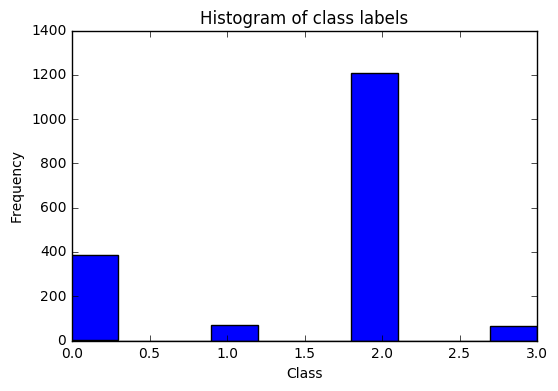

In [264]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = transformed_data.values[:,-1]

print("Distribution of class labels in train set:")
print(transformed_data['7'].value_counts())

plt.hist(labels)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Histogram of class labels")
plt.show()

    Majority of classes belong to class 2. So we should expect most clusters to be classified as 2.

## k-Means

In [241]:
class k_means:
    def __init__(self, data, k, initialization=None):
        self.data = data
        self.dim = data.shape[1] - 1
        self.x = self.data
        self.y = data[:,-1] # ignore for this assignment
        self.k = k
        self.start = np.vstack(initialization) if initialization else None
        self.centroids_history = list()
        self.assigned_cluster = None
        self.cluster_class = None
        self.prediction = None
        
    def initialize(self):
        '''
        In case no starting clusters are specified by the user, 
        k distinct points from the dataset are choosen 
        randomly as cluster centroids.
        '''
        
        if type(self.start) is type(None):
            from random import randint
            rand = []
            length = len(self.x)
            for n in range(self.k):
                index = randint(0, length - 1)
                
                # make sure we haven't already
                # picked this point
                if index in rand:
                    while(index in rand):
                        index = randint(0,length-1)
                
                rand.append(index)
                
            self.start = np.vstack([self.data[k] for k in rand])

        self.centroids_history.append(self.start)
            
    
    def kmeans(self, max_iter = 500, verbose = False):
        if self.k > len(self.x):
            return "Error: k > #(data points). Goodbye."
        # initialize first
        self.initialize()
        
        # remember previous centroid of each iteration
        # will be needed to terminate the algorithm 
        old_centroids = self.start
        new_centroids = self.mapping(old_centroids, verbose)
        if verbose:
            print("After first mapping, new centroids:")
            print(new_centroids)
        if(not np.array_equal(new_centroids, old_centroids)):
            equal = False
            step = 0
            
            while not equal and step < max_iter:
                old_centroids = new_centroids.copy()
                new_centroids = self.mapping(old_centroids,verbose)
                
                # stop when there is no more change
                equal = np.array_equal(old_centroids,new_centroids)
                step += 1
        
        # pop last result cuz it's been added twice
        # (during the last two iterations of while loop)
        self.centroids_history.pop(-1)

              
    def mapping(self, old_centroids,verbose):
        '''
        Maps each data point to each nearest cluster
        and recomputes the cluster centroids afterwards.
        '''
        # Create a list of lists to store 
        # data points which were 
        # assigned to a specific centroid.
        # Each list represents the data points 
        # of a specific centroid
        assignment = [list() for n in range(self.k)]
        labels = [list() for n in range(self.k)]
        
        # create var to store new centroids later 
        new_centroids = old_centroids.copy()

        # for each data point
        for data_point in self.data:
            dist = []

            # compute distance to each centroid
            for centroid in new_centroids:
                # append distance to a list
                dist.append(np.linalg.norm(centroid - data_point))

            # assign each data point to its nearest centroid
            c = np.argmin(dist)
            assignment[c].append(data_point)
            #labels[c] 
            
        if verbose:
            print("Computing new centroids:")
            
        # Compute new centroids 
        result=[]
        for n in range(self.k):
            result.append(np.mean(assignment[n], axis=0))
        
        if verbose:
            print("Retruning newly computed centroids:")
            print(result)
        
        # save result for plotting 
        self.centroids_history.append(np.vstack(result))
        self.assigned_cluster = assignment
        return result
    
    def get_labels(self):
        '''
        Returns a list that represents 
        which cluster each data point was assigned to.
        '''
        # hashmap, where the `key` represents the data point
        # and the `value` of that key represents the cluster 
        # the given data point was assigned to
        labels = dict() 
        cluster = 1
        for centroid in self.assigned_cluster:
            for data_point in centroid:
                labels['%s' % data_point] = cluster
            cluster += 1

                
        return [labels[str(data_point)] for data_point in self.data]
      
    def classify_clusters(self, verbose=False):
      '''
      Classify all objects of a cluster with the same class.
      This class is the majority class of the training examples of that cluster
      '''
      
      class_by_cluster = dict()
      for row,cluster in enumerate(self.get_labels()):
        if cluster not in class_by_cluster:
          class_by_cluster[cluster] = []
  
        class_by_cluster[cluster] += [transformed_data.values[row, -1]]
    
      if verbose:
        print(class_by_cluster)
        
      # Now we have a dictionary, where each `key` represents a cluster
      # and its `value` is a list, that contains all the classes that were 
      # assigned to that cluster
      
      # Determine majority class. In statistics this is called the `mode`
      from scipy import stats
      
      for key,val in class_by_cluster.items():
        class_by_cluster[key] = stats.mode(val)[0] # or np.argmax(np.bincount(val))
      
      self.cluster_class = class_by_cluster
      
      return class_by_cluster
    
    def predict(self):
      '''Predict classes based on how the
      clusters have been classified. Runtime 
      is extremly shitty with O(n^3).
      Feel free to improve.'''
      
      # To compute the accuracy, we first have to 
      # extract the rows of the data set 
      # that were assigned to each cluster. 
      
      # list of list to store the rows of each cluster
      rows = [list() for n in range(k)]
      
      # finally grab the row indices
      for cluster in range(self.k): 
        for clust_item in self.assigned_cluster[cluster]:
          index = 0
          for item in self.data:
            if np.array_equal(clust_item, item):
              rows[cluster].append(index)
              
            index += 1
            
      # next construct a vector of length 'number of rows'
      n_rows = self.data.shape[0] 
      pred = np.full((n_rows,), 0, dtype=np.int16)

      # Replace the data points by the actual class label
      # of each cluster. We have the clusters saved in 
      # ascending order in `row`, where each cluster 
      # contains a list with the according row indices
      # So indexng into row[0] should return all indices
      # of the dataset that are assigned to cluster 1.
      for cluster in range(self.k):
        pred[rows[cluster]] = self.cluster_class[cluster+1][0]
      
      self.prediction = pred
      # Output
      return self.prediction
    
    def accuracy(self, labels):
      '''Computes prediction accuracy'''
  
      return (100.0 * np.sum(self.prediction == labels) 
              / self.prediction.shape[0])
      
    
    def visualize(self):
      '''Plot cluster centroids in case the data is 2 dimensional'''
      
      if self.dim > 2: 
        return print("Can't visualize data with more than 2 dimensions.")
        
        x, y = self.x, self.y
        min_x = np.amin(self.start,axis=0)[0]
        max_x = np.amax(self.start, axis=0)[0]

        min_y = np.amin(self.start, axis=0)[1]
        max_y = np.amax(self.start, axis=0)[1]
        
        min_x = min(min_x, min(x))
        max_x = max(max_x, max(x))
        
        
        min_y = min(min_y, min(y))
        max_y = max(max_y, max(y))
        
        colors = ['b','g','r','c','m','y','k','w']
        plt.plot(x,y, 'o', markersize=6)
        plt.ylim(min_y-1,max_y+1)
        plt.xlim(min_x-1, max_x+1)
        
        size = 7
        for centroids in self.centroids_history:
            size += size*0.25
            for i in range(self.k):
                plt.plot(centroids[i][0], centroids[i][1], '*', 
                         markersize=size, color="{}".format(colors[i]))
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Scatterplot of Dataset')

        plt.show()
            

In [242]:
X = transformed_data.values
k = int(input("Specify k: "))

# initialize new starting points
print('Initializing Centroids')
test = k_means(X[:,:-1], k=k)
print("Done.")

# run k-Means
print("Running k-Means with k = %d" %k)
test.kmeans()
print("Done.")
print("Result of cluster classification:")
for key, val in test.classify_clusters(verbose=True).items():
  print("Cluster %d assigned to class %d" % (key, val))

Specify k: 4
Initializing Centroids
Done.
Running k-Means with k = 4
Done.
Result of cluster classification:
{1: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 3, 2, 2, 2, 2, 0, 0, 2, 0

####    All but Clusters are assigned to class 2. 

### Predict classes

In our case this step could have been handled easier by just taking the relative frequency of labels that belong to class 2. Since generally one can not expect to have all clusters assigned to the same class, I still implemented a predict() method that differentiates between each cluster's assigned class and predicts accordingly instead of just outputing a vecotr consisting of 2s. 

In [269]:
print("Predicting labels. This is gonna take a while (O(n^3) runtime...))")
print("...")
print("Done. ", test.predict())

Predicting labels. This is gonna take a while (O(n^3) runtime...))
...
Done.  [2 2 2 ..., 2 2 2]


### Computing accuracy

In [260]:
# labels from the beginning of this notebook
print("Prediction accuracy: %.2f%%" % test.accuracy(labels))

Prediction accuracy: 70.02%


*The result yields an accuracy of 70.02% which isn't better than a baseline classifier that classifies each input according to the most frequent class of the training set. Since the relative frequency of class 2 is 1210/1728 = 70.02% we're not doing any better here.*

### Append new column `cluster` to the data frame

In [248]:
data['cluster'] = test.get_labels()

# Display last 10 entries
data.tail(10)

,1,2,3,4,5,6,7,cluster
1718,low,low,5-more,4.0,big,high,vgood,2
1719,low,low,5-more,more,small,low,unacc,2
1720,low,low,5-more,more,small,med,acc,2
1721,low,low,5-more,more,small,high,good,2
1722,low,low,5-more,more,med,low,unacc,2
1723,low,low,5-more,more,med,med,good,2
1724,low,low,5-more,more,med,high,vgood,2
1725,low,low,5-more,more,big,low,unacc,2
1726,low,low,5-more,more,big,med,good,2
1727,low,low,5-more,more,big,high,vgood,2
